**Introduction**

This notebook is for the major project submission on the Facial emotion dection  task. It contains the following sections:


*   Conventional ML approach
*   Deep learning approach



#**Conventional ML Model**

I will apply PCA (Principal Component analysis) and finally, SVM to predict the facial emotion detection as this model is well known for multi-label classfication. We will also try other classification model and check the model accuracy. The reason for choosing PCA is it assist in reducing dimension and preserve most important features, which results in better accuracy on the data.


In [1]:
import os
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from os.path import join
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score

Loading npy files

In [2]:
image_size = 48
Emotion = {0:'fearful',1:'disgusted',2:'sad',3:'happy',4:'surprised',5:'neutral',6:'Angry'}
dataset_directory = '/content/'  ## CHANGE TO YOUR OWN DIRECTORY

images_train = np.load(join(dataset_directory, 'Training_data_images.npy'))
labels_train = np.load(join(dataset_directory, 'Training_data_labels.npy'))

images_test_public = np.load(join(dataset_directory, 'PublicTest_data_images.npy'))

images_train.shape

(9328, 48, 48)

In [3]:
for i,j in enumerate(Emotion):
    print(Emotion[i])

fearful
disgusted
sad
happy
surprised
neutral
Angry


Lets verify our dataset

In [4]:
print("There are {} images in the dataset".format(len(images_train)))
print("There are {} unique emotions in the dataset".format([Emotion[i] for i,j in enumerate(Emotion)]))
print("Size of each image is {}x{}".format(images_train.shape[1],images_train.shape[2]))
print("Pixel values were scaled to [0,1] interval. e.g:{}".format(images_train[0][0,:4]))

There are 9328 images in the dataset
There are ['fearful', 'disgusted', 'sad', 'happy', 'surprised', 'neutral', 'Angry'] unique emotions in the dataset
Size of each image is 48x48
Pixel values were scaled to [0,1] interval. e.g:[0.25098039 0.24705882 0.2745098  0.2745098 ]


Show random 10 images from the dataset

In [5]:
def show_7_Unique_emotion(images, unique_ids):
    #Creating 2X10 subplots in  18x9 figure size
    fig, axarr=plt.subplots(nrows=1, ncols=7, figsize=(18, 9))
    #For easy iteration flattened 2X10 subplots matrix to 20 array
    axarr=axarr.flatten()
    
    #iterating over user ids
    for unique_id in unique_ids:
        image_index=unique_id*7
        axarr[unique_id].imshow(images[image_index], cmap='gray')
        axarr[unique_id].set_xticks([])
        axarr[unique_id].set_yticks([])
        axarr[unique_id].set_title("face id:{}".format(Emotion[unique_id]))
    plt.suptitle("Show People with Unique emotions")

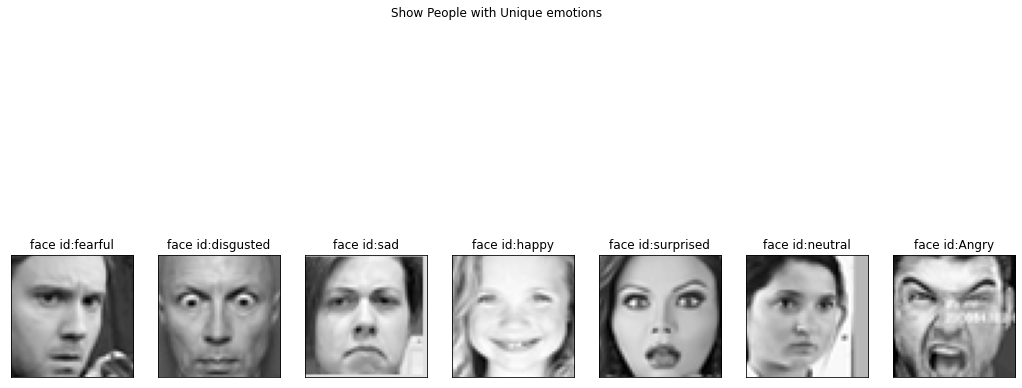

In [6]:
show_7_Unique_emotion(images_train, [i for i,j in enumerate(Emotion)])

Reshaping data to 2-Dimension

In [7]:
image_reshape = images_train.reshape(images_train.shape[0], -1) 
image_reshape.shape

(9328, 2304)

Breaking down the data into test and train set

In [8]:
X = image_reshape
y = labels_train

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3, stratify=y, random_state=0)
print("X_train shape:",X_train.shape)
print("y_train shape:{}".format(y_train.shape))

X_train shape: (6529, 2304)
y_train shape:(6529,)


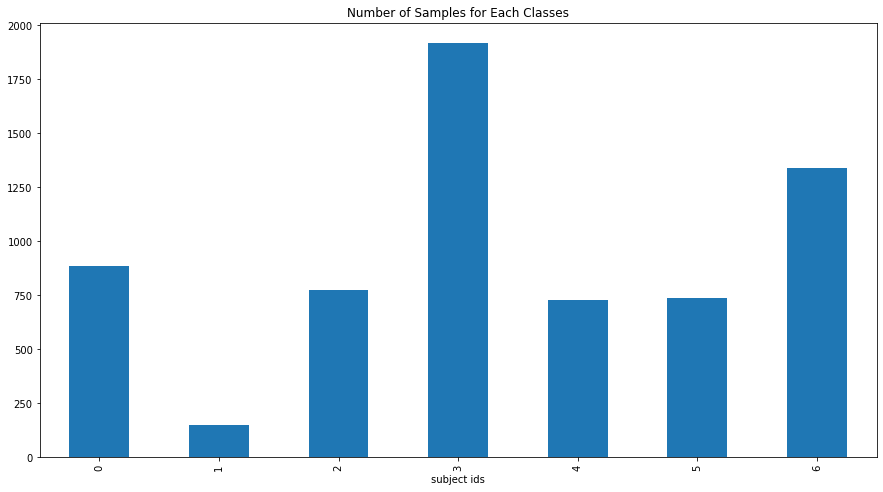

In [9]:
y_frame=pd.DataFrame()
y_frame['subject ids']=y_train
y_frame.groupby(['subject ids']).size().plot.bar(figsize=(15,8),title="Number of Samples for Each Classes")

Here, we can see that, we have maximum images for 3('Happy') and 6('Angry').



Apply PCA

In [10]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
pca.fit(X)
X_pca=pca.transform(X)

Finding optimum number of Principle Component

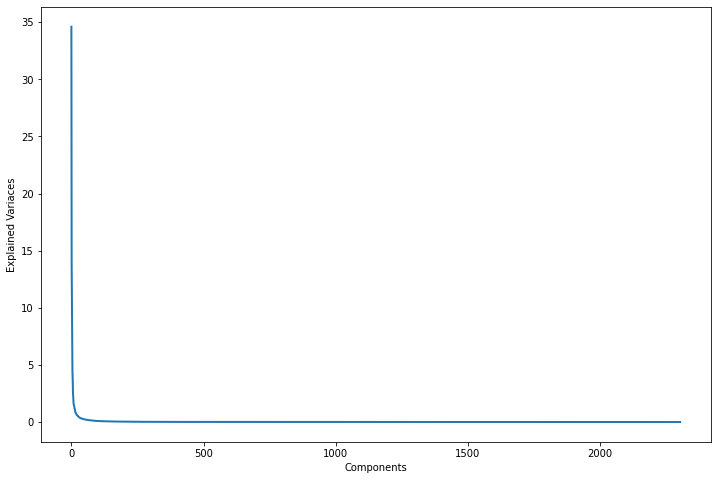

In [11]:
pca=PCA()
pca.fit(X)

plt.figure(1, figsize=(12,8))

plt.plot(pca.explained_variance_, linewidth=2)
 
plt.xlabel('Components')
plt.ylabel('Explained Variaces')
plt.show()

n the figure above, it can be seen that approx 100 and more PCA components represent the same data. Now let's make the classification process using 100 PCA components.


In [16]:
n_components=100

In [17]:
pca=PCA(n_components=n_components, whiten=True)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

Show Eigen Faces

Text(0.5, 0.98, 'All Eigen Faces')

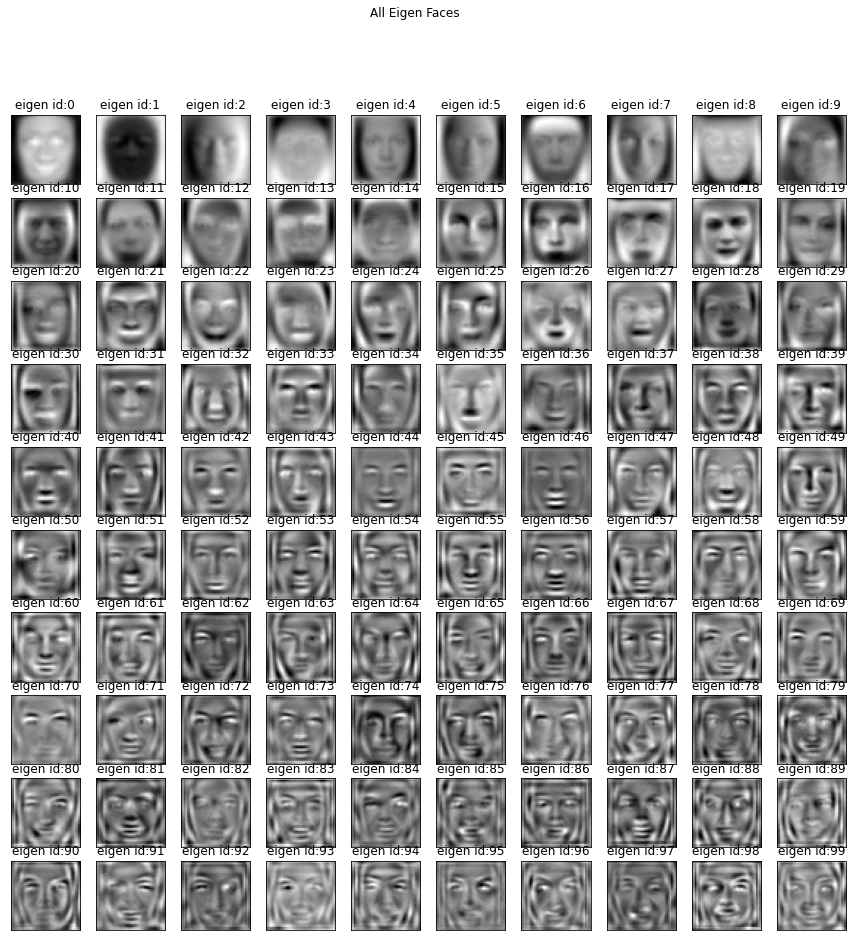

In [18]:
number_of_eigenfaces=len(pca.components_)
eigen_faces=pca.components_.reshape((number_of_eigenfaces, images_train.shape[1], images_train.shape[2]))

cols=10
rows=int(number_of_eigenfaces/cols)
fig, axarr=plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))
axarr=axarr.flatten()
for i in range(number_of_eigenfaces):
    axarr[i].imshow(eigen_faces[i],cmap="gray")
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])
    axarr[i].set_title("eigen id:{}".format(i))
plt.suptitle("All Eigen Faces".format(10*"=", 10*"="))

Classification Results

In [19]:
X_train_pca=pca.transform(X_train)
X_test_pca=pca.transform(X_test)

Calculating Accuracy

In [20]:
from sklearn import metrics
clf = SVC()
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)
print("accuracy score:{:.4f}".format(metrics.accuracy_score(y_test, y_pred)))

accuracy score:0.5263


We have received 52.63% accuracy using PCA.

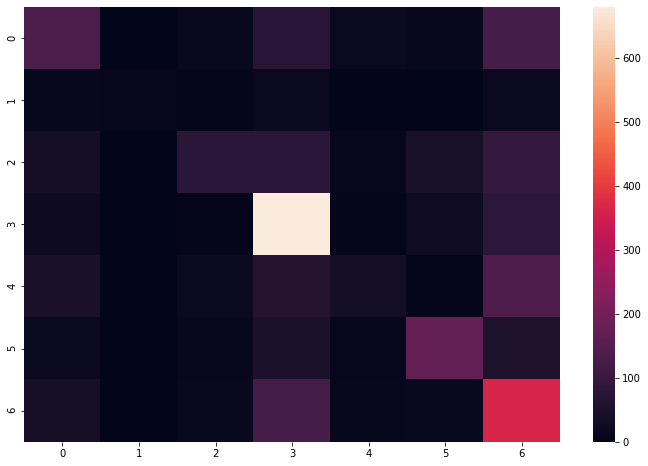

In [21]:
import seaborn as sns
plt.figure(1, figsize=(12,8))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred))

In the confusion matrix, we can see higer prediction for 3(Happy),5(Neutral) 
emotions

In [22]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.43      0.36      0.39       380
           1       1.00      0.14      0.25        63
           2       0.50      0.23      0.31       332
           3       0.63      0.83      0.71       821
           4       0.38      0.11      0.17       313
           5       0.62      0.56      0.59       316
           6       0.42      0.64      0.51       574

    accuracy                           0.53      2799
   macro avg       0.57      0.41      0.42      2799
weighted avg       0.52      0.53      0.49      2799



The prevision and recall says the model predicted better score for 3(Happy),5(Neutral) emotions  

**Checking for better accuracy using other classification model**

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

models=[]
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(("Logistic Regression",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("KNN",KNeighborsClassifier(n_neighbors=5)))
models.append(("DT",DecisionTreeClassifier()))
models.append(("SVM",SVC()))


for name, model in models:
    
    clf=model

    clf.fit(X_train_pca, y_train)

    y_pred=clf.predict(X_test_pca)
    print(10*"=","{} Result".format(name).upper(),10*"=")
    print("Accuracy score:{:0.2f}".format(metrics.accuracy_score(y_test, y_pred)))
    print()

========== LDA RESULT ==========
Accuracy score:0.46

========== LOGISTIC REGRESSION RESULT ==========
Accuracy score:0.46

========== NB RESULT ==========
Accuracy score:0.40

========== KNN RESULT ==========
Accuracy score:0.39

========== DT RESULT ==========
Accuracy score:0.35

========== SVM RESULT ==========
Accuracy score:0.53



From the above result, we can say that SVM is the best model with accuracy 53%.

Cross Validation Result

In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
pca=PCA(n_components=n_components, whiten=True)
pca.fit(X)
X_pca=pca.transform(X)
for name, model in models:
    kfold=KFold(n_splits=5, shuffle=True, random_state=0)
    cv_scores=cross_val_score(model, X_pca, y, cv=kfold)
    print("{} mean cross validations score:{:.4f}".format(name, cv_scores.mean()))

LDA mean cross validations score:0.4655
Logistic Regression mean cross validations score:0.4693
NB mean cross validations score:0.3928
KNN mean cross validations score:0.3883
DT mean cross validations score:0.3403
SVM mean cross validations score:0.5367


From the Cross Validation result, we can say that SVM is the best model with accuracy of 53.67%.



In [25]:
svm=SVC()
svm.fit(X_train_pca, y_train)
y_pred=svm.predict(X_test_pca)
print("Accuracy score:{:.4f}".format(metrics.accuracy_score(y_test, y_pred)))

Accuracy score:0.5263


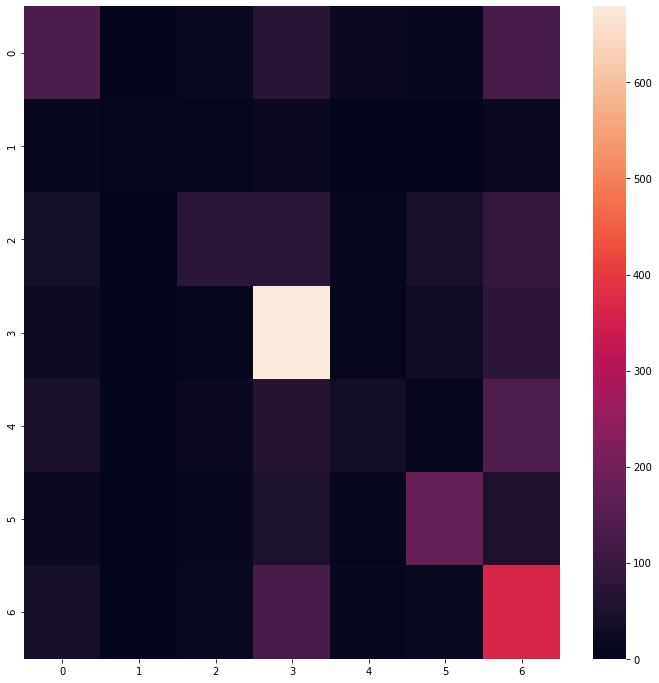

In [26]:
cm=metrics.confusion_matrix(y_test, y_pred)
plt.subplots(1, figsize=(12,12))
sns.heatmap(cm)

In [27]:
print("Classification Results:\n{}".format(metrics.classification_report(y_test, y_pred)))

Classification Results:
              precision    recall  f1-score   support

           0       0.43      0.36      0.39       380
           1       1.00      0.14      0.25        63
           2       0.50      0.23      0.31       332
           3       0.63      0.83      0.71       821
           4       0.38      0.11      0.17       313
           5       0.62      0.56      0.59       316
           6       0.42      0.64      0.51       574

    accuracy                           0.53      2799
   macro avg       0.57      0.41      0.42      2799
weighted avg       0.52      0.53      0.49      2799



**Hyperparameter Tunning:RandomizedSearchCV**

The reason for using Hyper parameter is to tune the model and get the best model generalization performance. The computation cost was high using GridSearchCV, therefore, I have used RandomizedSearchCV. The model took too long to execute, so I am using 1 iteration.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
clf = RandomizedSearchCV(svm.SVC(gamma='auto'), {
    'C': [90,100],
    'kernel': ['rbf','linear']
}, cv=5, return_train_score=False,n_iter = 1)

In [ ]:
clf.fit(X_train_pca, y_train)

In [ ]:
clf.cv_results_ 

Inserting the result into a dataframe

In [31]:
df = pd.DataFrame(clf.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.78062,0.027978,0.501519,0.009897,rbf,100,"{'kernel': 'rbf', 'C': 100}",0.445636,0.482389,0.47856,0.493109,0.468199,0.473579,0.016085,1


Looking for a values and score in parameters

In [32]:
df[['param_C','param_kernel','mean_test_score']]

,param_C,param_kernel,mean_test_score
0,50,rbf,0.473426
1,100,rbf,0.473119


In [ ]:
clf.best_params_

Using Conventional ML, the final model that produced the best-performing predictions for the Kaggle submission (accuracy 52.63%) was a PCA with SVM with a rbf kernel.

# Deep learning Approach




I will be using **Convolutional Neural Network** to classify facial emotions. The CNN model is good for extracting the features of the images and is widely used for image classification.

In [33]:
import keras
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation,BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from skimage.transform import resize

Reshaping the data inorder to fit in CNN model

In [28]:
images_train=images_train.reshape(len(images_train),48,48,1)
images_train.shape

(9328, 48, 48, 1)

Dividing the data into testing and validation dataset

In [30]:
train_split, val_split = 0.7, 0.15
idx_val = int(train_split * len(images_train))
idx_test = int((train_split + val_split) * len(images_train))
train_X = images_train[:idx_val]
val_X = images_train[idx_val:idx_test]
test_X = images_train[idx_test:]

In [31]:
idx_val = int(train_split * len(labels_train))
idx_test = int((train_split + val_split) * len(labels_train))
train_y = labels_train[:idx_val]
val_y = labels_train[idx_val:idx_test]
test_y = labels_train[idx_test:]

Normalizing the data

In [35]:
# normalize data
train_X = train_X.astype('float32') 
val_X = val_X.astype('float32') 
test_X = test_X.astype('float32') 

num_classes = len([i for i,j in enumerate(Emotion)])
print(num_classes)
# convert labels to one-hot vectors
train_y = keras.utils.to_categorical(train_y, num_classes)
val_y = keras.utils.to_categorical(val_y, num_classes)
test_y = keras.utils.to_categorical(test_y, num_classes)

7


Let's get the summary of what we have

In [36]:
# summary
print("finished loading %d images from %d categories"%(len(images_train), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(train_X), len(val_X), len(test_X)))
print("training data shape: ", train_X.shape)
print("training labels shape: ", train_y.shape)

finished loading 9328 images from 7 categories
train / validation / test split: 6529, 1399, 1400
training data shape:  (6529, 48, 48, 1)
training labels shape:  (6529, 7)


Now, lets define the architecture of CNN model

I will define our CNN with the following architecture:


1.   4 convolutional layer
2.   2 fully connected layer

*  The convolutional layer will extract the most important features from the data set and fully connected layer will focus on using these features to classify the images,
*  I have used relu function to introduce non linearity in the model. We can also use other functions like signoid, tanh. However, Relu fuction are found to perform faster and better in such situation.
* The resason for using pooling is to reduce the dimentionality of the feature while retaining the most important features.
* Batch normalization is used to provide performance and stability on the model.
* Dropout is used to redue overfitting by randoming not updating the weights of the model.
* I have choose softmax on the last layer as it is mostly used for multi-label classification.





In [38]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(50,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(100,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(100,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(400,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(num_classes, activation='softmax'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 48, 48, 50)        500       
_________________________________________________________________
batch_normalization_6 (Batch (None, 48, 48, 50)        200       
_________________________________________________________________
activation_6 (Activation)    (None, 48, 48, 50)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 50)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 24, 24, 50)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 100)       125100    
_________________________________________________________________
batch_normalization_7 (Batch (None, 24, 24, 100)      

We've created a medium-sized network with ~1.6 million weights and biases (the parameters). Most of them are leading into the one pre-softmax fully-connected layer "dense_5".

We can now go ahead and train our model for 100 epochs with a batch size of 128. We'll also record its history so we can plot the loss over time later.

In [39]:
opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Training the model using 100 epochs

In [42]:
history = model.fit(train_X, train_y,
                    batch_size=128,
                    epochs=100,
                    validation_data=(val_X, val_y))

Epoch 1/100
52/52 [==============================] - 1s 28ms/step - loss: 0.8806 - accuracy: 0.6751 - val_loss: 1.1723 - val_accuracy: 0.6197
Epoch 2/100
52/52 [==============================] - 1s 27ms/step - loss: 0.8799 - accuracy: 0.6756 - val_loss: 1.1574 - val_accuracy: 0.6083
Epoch 3/100
52/52 [==============================] - 1s 27ms/step - loss: 0.8744 - accuracy: 0.6782 - val_loss: 1.1194 - val_accuracy: 0.6247
Epoch 4/100
52/52 [==============================] - 1s 27ms/step - loss: 0.8490 - accuracy: 0.6866 - val_loss: 1.2846 - val_accuracy: 0.5861
Epoch 5/100
52/52 [==============================] - 1s 27ms/step - loss: 0.8532 - accuracy: 0.6787 - val_loss: 1.1317 - val_accuracy: 0.6197
Epoch 6/100
52/52 [==============================] - 1s 27ms/step - loss: 0.8355 - accuracy: 0.6920 - val_loss: 1.1437 - val_accuracy: 0.6133
Epoch 7/100
52/52 [==============================] - 1s 27ms/step - loss: 0.8396 - accuracy: 0.6845 - val_loss: 1.0833 - val_accuracy: 0.6204
Epoch 

Let's plot the validation loss and validation accuracy over time.

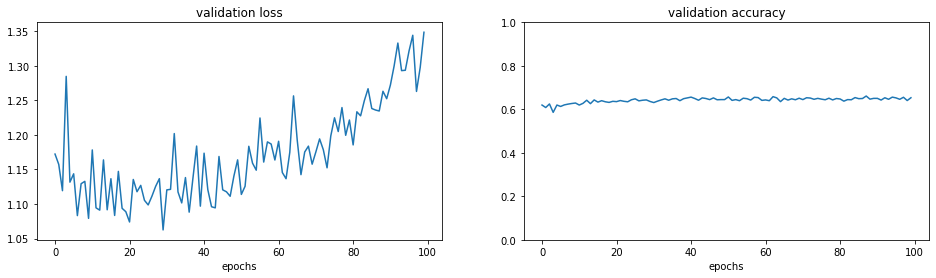

In [44]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

The epochs history shows that accuracy remains consistent and achieved 64% accuracy on both training and validation set upto 60 epoch, but after that the model starts overfitting training data.

In [45]:
loss, accuracy = model.evaluate(test_X, test_y, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 1.3801778554916382
Test accuracy: 0.6349999904632568


## Optimizing using Keras Tunear to see if we can increase the accuracy on the model

In [57]:
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=25, max_value=500, step=20),
        kernel_size=hp.Choice('conv_1_kernel', values = [2,8]),
        activation='relu',
        input_shape=(48,48,1)
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=25, max_value=500, step=20),
        kernel_size=hp.Choice('conv_2_kernel', values = [2,8]),
        activation='relu'
    ),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=25, max_value=500, step=20),
        activation='relu'
    ),
    keras.layers.Dense(7, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [58]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [61]:
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=5,directory='output',project_name="Facial Emotion22")

Applying tuner search till 3 epoch

In [62]:
tuner_search.search(train_X,labels_train,epochs=3,validation_split=0.1)

Epoch 1/3
184/184 [==============================] - 3s 15ms/step - loss: 1.8282 - accuracy: 0.3072 - val_loss: 1.5535 - val_accuracy: 0.4319
Epoch 2/3
184/184 [==============================] - 3s 16ms/step - loss: 1.4970 - accuracy: 0.4508 - val_loss: 1.4430 - val_accuracy: 0.4824
Epoch 3/3
184/184 [==============================] - 3s 16ms/step - loss: 1.3368 - accuracy: 0.5174 - val_loss: 1.3656 - val_accuracy: 0.4962


Epoch 1/3
184/184 [==============================] - 17s 91ms/step - loss: 2.2554 - accuracy: 0.2658 - val_loss: 1.7724 - val_accuracy: 0.3078
Epoch 2/3
184/184 [==============================] - 12s 66ms/step - loss: 1.7914 - accuracy: 0.2922 - val_loss: 1.7667 - val_accuracy: 0.3078
Epoch 3/3
184/184 [==============================] - 12s 66ms/step - loss: 1.7903 - accuracy: 0.2922 - val_loss: 1.7671 - val_accuracy: 0.3078


Epoch 1/3
184/184 [==============================] - 13s 70ms/step - loss: 55.4093 - accuracy: 0.2789 - val_loss: 1.7896 - val_accuracy: 0.3139
Epoch 2/3
184/184 [==============================] - 12s 63ms/step - loss: 1.7998 - accuracy: 0.2922 - val_loss: 1.7749 - val_accuracy: 0.3078
Epoch 3/3
184/184 [==============================] - 12s 63ms/step - loss: 1.7963 - accuracy: 0.2922 - val_loss: 1.7694 - val_accuracy: 0.3078


Epoch 1/3
184/184 [==============================] - 16s 86ms/step - loss: 2.2516 - accuracy: 0.3038 - val_loss: 1.5568 - val_accuracy: 0.4074
Epoch 2/3
184/184 [==============================] - 15s 81ms/step - loss: 1.5155 - accuracy: 0.4273 - val_loss: 1.4065 - val_accuracy: 0.4686
Epoch 3/3
184/184 [==============================] - 23s 124ms/step - loss: 1.3258 - accuracy: 0.5097 - val_loss: 1.3624 - val_accuracy: 0.5115


Epoch 1/3
184/184 [==============================] - 16s 88ms/step - loss: 202.7856 - accuracy: 0.2643 - val_loss: 1.7689 - val_accuracy: 0.3078
Epoch 2/3
184/184 [==============================] - 13s 73ms/step - loss: 1.7908 - accuracy: 0.2922 - val_loss: 1.7686 - val_accuracy: 0.3078
Epoch 3/3
184/184 [==============================] - 13s 73ms/step - loss: 1.7906 - accuracy: 0.2922 - val_loss: 1.7644 - val_accuracy: 0.3078


INFO:tensorflow:Oracle triggered exit


In [63]:
model=tuner_search.get_best_models(num_models=1)[0]

In [64]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 47, 47, 205)       1025      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 145)       1902545   
_________________________________________________________________
flatten (Flatten)            (None, 232000)            0         
_________________________________________________________________
dense (Dense)                (None, 325)               75400325  
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 2282      
Total params: 77,306,177
Trainable params: 77,306,177
Non-trainable params: 0
_________________________________________________________________


This is the model summary that we have received that includes how many number of layers we need to include in CNN model.

In [65]:
history1= model.fit(images_train, labels_train, epochs=10, validation_split=0.1, initial_epoch=3)

Epoch 4/10
263/263 [==============================] - 17s 64ms/step - loss: 1.2262 - accuracy: 0.5582 - val_loss: 1.2972 - val_accuracy: 0.5166
Epoch 5/10
263/263 [==============================] - 16s 63ms/step - loss: 1.0390 - accuracy: 0.6310 - val_loss: 1.2916 - val_accuracy: 0.5434
Epoch 6/10
263/263 [==============================] - 17s 63ms/step - loss: 0.8075 - accuracy: 0.7133 - val_loss: 1.3730 - val_accuracy: 0.5434
Epoch 7/10
263/263 [==============================] - 16s 63ms/step - loss: 0.5374 - accuracy: 0.8181 - val_loss: 1.6792 - val_accuracy: 0.5316
Epoch 8/10
263/263 [==============================] - 16s 62ms/step - loss: 0.3225 - accuracy: 0.8942 - val_loss: 1.9339 - val_accuracy: 0.5284
Epoch 9/10
263/263 [==============================] - 16s 62ms/step - loss: 0.1598 - accuracy: 0.9520 - val_loss: 2.4517 - val_accuracy: 0.5005
Epoch 10/10
263/263 [==============================] - 16s 63ms/step - loss: 0.0999 - accuracy: 0.9743 - val_loss: 2.8713 - val_accuracy

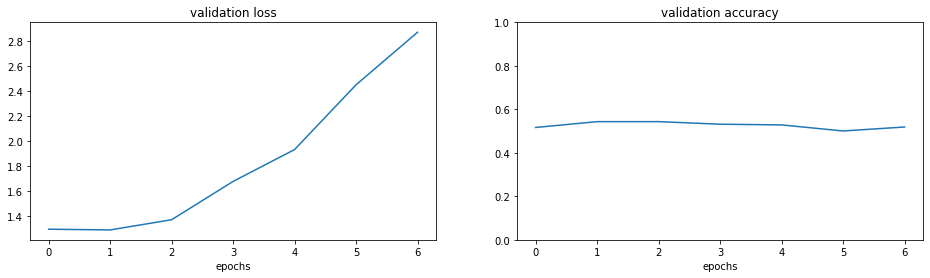

In [67]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history1.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history1.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

The epochs history shows that accuracy remains consistent and achieved 55% accuracy on both training and validation set upto 2 epoch, but after that the model starts overfitting training data. Therefore, using keras tuning, the accuracy is not increasing.

# Applying Transfer learning

Reshaping the image so that it can fitted to transfer learning model

In [68]:
images= np.empty((len(images_train),75,75,3))
resized_data = []
i=0
for j in images_train:
        new_train = j.reshape(48,48)
        reshape = resize(new_train,(75,75),order = 3,mode = "constant")
        ret = np.empty((75,75,3))
        ret[:,:,0] = reshape
        ret[:,:,1] = reshape
        ret[:,:,2] = reshape
        images[i,:,:,:] = ret
        i +=1

In [69]:
images.shape

(9328, 75, 75, 3)

Dividing the data into test and train data set.

In [70]:
train_split, val_split = 0.7, 0.15
idx_val = int(train_split * len(images))
idx_test = int((train_split + val_split) * len(images))
train_X = images[:idx_val]
val_X = images[idx_val:idx_test]
test_X = images[idx_test:]

In [71]:
idx_val = int(train_split * len(labels_train))
idx_test = int((train_split + val_split) * len(labels_train))
train_Y = labels_train[:idx_val]
val_Y = labels_train[idx_val:idx_test]
test_Y = labels_train[idx_test:]

In [72]:
# normalize data
train_X = train_X.astype('float32') 
val_X = val_X.astype('float32') 
test_X = test_X.astype('float32') 

num_classes = len([i for i,j in enumerate(Emotion)])
print(num_classes)
train_Y = keras.utils.to_categorical(train_Y, num_classes)
val_Y = keras.utils.to_categorical(val_Y, num_classes)
test_Y = keras.utils.to_categorical(test_Y, num_classes)

7


Using InceptionResNetV2 model

In [73]:
InceptionResNetV2 = keras.applications.InceptionResNetV2(input_shape = train_X.shape[1:],weights='imagenet', include_top=False)
InceptionResNetV2.summary()

219062272/219055592 [==============================] - 2s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 37, 37, 32)   96          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 37, 37, 32)   0           batch_normalization[0][0]        
_____________

In [74]:
from keras.layers import GlobalAveragePooling2D, Dense 

x = InceptionResNetV2.output

x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation = 'relu')(x)
predictions = Dense(num_classes, activation = 'softmax')(x)

# The model we will train
model = Model(inputs = InceptionResNetV2.input, outputs = predictions)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 37, 37, 32)   96          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 37, 37, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [75]:
from keras.optimizers import Adam, SGD

# make all layers untrainable by freezing weights
for layer in InceptionResNetV2.layers:
    layer.trainable = False

model.compile(
    optimizer   = Adam(lr = 1e-3, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.0), 
    loss        = 'categorical_crossentropy', 
    metrics     = ['accuracy'])

Applying 30 epochs

In [76]:
history3 = model.fit(train_X, train_y, 
                         batch_size=20, 
                         epochs=30, 
                         validation_data=(val_X,val_Y),shuffle=True)

Epoch 1/30
327/327 [==============================] - 14s 42ms/step - loss: 1.9403 - accuracy: 0.3913 - val_loss: 1.5183 - val_accuracy: 0.4325
Epoch 2/30
327/327 [==============================] - 11s 33ms/step - loss: 1.4575 - accuracy: 0.4615 - val_loss: 1.5079 - val_accuracy: 0.4503
Epoch 3/30
327/327 [==============================] - 11s 34ms/step - loss: 1.3913 - accuracy: 0.4858 - val_loss: 1.4589 - val_accuracy: 0.4610
Epoch 4/30
327/327 [==============================] - 11s 34ms/step - loss: 1.3317 - accuracy: 0.5142 - val_loss: 1.5183 - val_accuracy: 0.4568
Epoch 5/30
327/327 [==============================] - 11s 33ms/step - loss: 1.2895 - accuracy: 0.5258 - val_loss: 1.4146 - val_accuracy: 0.4746
Epoch 6/30
327/327 [==============================] - 11s 33ms/step - loss: 1.2360 - accuracy: 0.5462 - val_loss: 1.4124 - val_accuracy: 0.4825
Epoch 7/30
327/327 [==============================] - 11s 33ms/step - loss: 1.1956 - accuracy: 0.5664 - val_loss: 1.5067 - val_accuracy:

In [77]:
# ensure the  layer is trainable/not frozen
for layer in model.layers:
    layer.trainable = True

In [78]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('Emotion_little_vgg.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )
callbacks = [checkpoint,earlystop]


model.compile(
    optimizer   = SGD(lr = 1e-3, momentum = 0.9, decay = 0.0, nesterov = True),
    loss        = 'categorical_crossentropy', 
    metrics     = ['accuracy'])

In [79]:
history4 = model.fit(train_X, train_Y, 
                         batch_size=20, 
                         epochs=10, 
                         validation_data=(val_X,val_Y),callbacks=callbacks)

Epoch 1/10
327/327 [==============================] - ETA: 0s - loss: 1.5254 - accuracy: 0.4786
Epoch 00001: val_loss improved from inf to 1.20239, saving model to Emotion_little_vgg.h5
327/327 [==============================] - 37s 113ms/step - loss: 1.5254 - accuracy: 0.4786 - val_loss: 1.2024 - val_accuracy: 0.5461
Epoch 2/10
327/327 [==============================] - ETA: 0s - loss: 1.0000 - accuracy: 0.6274
Epoch 00002: val_loss did not improve from 1.20239
327/327 [==============================] - 31s 93ms/step - loss: 1.0000 - accuracy: 0.6274 - val_loss: 1.2587 - val_accuracy: 0.5647
Epoch 3/10
327/327 [==============================] - ETA: 0s - loss: 0.7713 - accuracy: 0.7151
Epoch 00003: val_loss improved from 1.20239 to 1.15964, saving model to Emotion_little_vgg.h5
327/327 [==============================] - 33s 102ms/step - loss: 0.7713 - accuracy: 0.7151 - val_loss: 1.1596 - val_accuracy: 0.6040
Epoch 4/10
327/327 [==============================] - ETA: 0s - loss: 0.5726

Our validation accuracy hovers close to 65.55% towards in 8 epoachs, which is more than 2% improvement on the original network trained from scratch.

Let's plot the validation loss and accuracy again

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history4.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history4.history["val_acc"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

The epochs history shows that accuracy remains consistent and achieved 65.55% accuracy on both training and validation set upto 5 epoch, but after that the model starts overfitting training data.

Test Prediction

In [80]:
images_test_public=images_test_public.reshape(len(images_test_public),48,48,1)
images_test_public.shape

(1136, 48, 48, 1)

In [81]:
images= np.empty((len(images_test_public),75,75,3))
resized_data = []
i=0
for j in images_test_public:
        new_train = j.reshape(48,48)
        reshape = resize(new_train,(75,75),order = 3,mode = "constant")
        ret = np.empty((75,75,3))
        ret[:,:,0] = reshape
        ret[:,:,1] = reshape
        ret[:,:,2] = reshape
        images[i,:,:,:] = ret
        i +=1

In [82]:
predictions = model.predict(x= images)
classes = np.argmax(predictions, axis = 1)
print(set(classes))

{0, 1, 2, 3, 4, 5, 6}


In [83]:
outputPredict = pd.DataFrame(classes)
outputPredict.to_csv('Predicted_Output_final_20201104.csv')

# Discussion of Model Performance and Implementation

Comparing the final conventional ML and deep learning models, the deep learning performed better by 10% on the public test set.  The deep learning model ranked #15 out of 8 submissions on the public test set, with the top-performing system having 71.39% accuracy, and a majority class baseline having 65% to 69% accuracy. In the private dataset, I ranked #15 with slight increase of 2.5% in accuracy. The validation and public dataset had approximately similar accuray level.